# Feature Engineering

In [1]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

import math
pd.set_option('display.float_format', '{:.2f}'.format)
pd.options.display.max_columns = None

from numpy import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import eli5
from eli5.sklearn import PermutationImportance

from matplotlib import pyplot as plt

In [2]:
games = pd.read_csv('./data/games.csv')
players = pd.read_csv('./data/players.csv')
plays = pd.read_csv('./data/plays.csv')
tackles = pd.read_csv('./data/tackles.csv')
week1 = pd.read_csv('./data/tracking_week_1.csv')
week2 = pd.read_csv('./data/tracking_week_2.csv')
week3 = pd.read_csv('./data/tracking_week_3.csv')
week4 = pd.read_csv('./data/tracking_week_4.csv')
week5 = pd.read_csv('./data/tracking_week_5.csv')
week6 = pd.read_csv('./data/tracking_week_6.csv')
week7 = pd.read_csv('./data/tracking_week_7.csv')
week8 = pd.read_csv('./data/tracking_week_8.csv')
week9 = pd.read_csv('./data/tracking_week_9.csv')

To combine all the 9 weeks of tracking data into one dataframe. 

In [3]:
all_weeks = [week1, week2, week3, week4, week5, week6, week7, week8, week9]
weeks = pd.concat(all_weeks)
games_weeks = games[['gameId', 'week']]

To first convert the players' heights into total inches and then to get the total mass of the players by combining their height and weight. 

In [4]:
players['totalInches'] = (players.height.str.split("-").str[0].astype(int) * 12) + (
    players.height.str.split("-").str[1].astype(int)
)
players['mass'] = (players['totalInches']/12 * players['weight']).round(2)

Since playId is "...not unique across games" I'll combine that column and gameId to create a new variable called gamePlayId to have a unique identifier for each play.

In [5]:
plays['gamePlayId'] = plays[['gameId', 'playId']].astype(str).apply(lambda x: ''.join(x), axis=1)
plays['gamePlayId'] = plays['gamePlayId'].astype('int64')

To add the week number to each of the plays. 

In [6]:
plays = pd.merge(plays, games_weeks, on='gameId', how='left')

To again create the unique gamePlayId value for each play. Since I'll be creating a tackles value later in this work, I've changed the name of the tackle column to tackler. 

In [7]:
tackles['gamePlayId'] = tackles[['gameId', 'playId']].astype(str).apply(lambda x: ''.join(x), axis=1)
tackles['gamePlayId'] = tackles['gamePlayId'].astype('int64')
tackles.rename(columns={'tackle':'tackler'}, inplace=True)

To add the game week to the plays in the tackles dataframe. 

In [8]:
tackles = pd.merge(tackles, games_weeks, on=['gameId'], how='left')

To again create the unique gamePlayId value for the weeks dataframe and drop the columns I won't need in the future. 

In [9]:
weeks['gamePlayId'] = weeks[['gameId', 'playId']].astype(str).apply(lambda x: ''.join(x), axis=1)
weeks['gamePlayId'] = weeks['gamePlayId'].astype('int64')
weeks.drop(columns=['time', 'jerseyNumber', 'playDirection'], inplace=True)

To merge the tackles and players dataframes into the primary weeks dataframe, and then drop some of the players columns I won't need going forward. 

In [10]:
weeks = pd.merge(weeks, tackles, on=['gameId','playId','nflId','gamePlayId'], how='left')
weeks = weeks.drop('week', axis=1)
weeks = pd.merge(weeks, players, on=['nflId','displayName'], how='left')
weeks.drop(['height', 'weight', 'birthDate', 'collegeName'], axis=1, inplace=True)

One of the most important concepts in tackling is how many yards the ball carrier gained after they received the ball, either by a handoff or a caught pass. I'm calling that event a transfer and I'll change the handoff and pass_outcome_caught event values to a transfer. 

Before making this change I want to create a new column called 'playType' to identify pass vs run plays based on these two event types. 

In [11]:
weeks['playType'] = np.where(weeks['event']=='handoff', 'run', 0)
weeks['playType'] = np.where(weeks['event']=='pass_outcome_caught', 'pass', weeks['playType'])

# To Expand Play Types To All Rows in Each gamePlayId Group

Initially the play type value is only showing up the frame where it occured. I want to expand that to all the frames in each play. 

In [12]:
weeks_playtype = weeks[['gamePlayId', 'playType']]
grouped_playtype = weeks_playtype.groupby(['gamePlayId']).max().reset_index()

There are still a small number of plays that have not been identified as a run or pass because they didn't contain a handoff or a caught pass. I'm calling these direct plays and assuming they occured from either a quarterback sack, a quarterback run or a run with a direct snap to a running back or receiver. 

In [13]:
grouped_playtype['playType'] = np.where(grouped_playtype['playType']=='0', 'direct', grouped_playtype['playType'])
grouped_playtype['playType'].value_counts()

run       5876
pass      5646
direct     964
Name: playType, dtype: int64

In [14]:
weeks = pd.merge(weeks, grouped_playtype, on=['gamePlayId'], how='left')
weeks = weeks.drop('playType_x', axis=1)
weeks.rename(columns={'playType_y':'playType'}, inplace=True)

# Developing a Ball Location Metric

I want to be able to track where the ball is at each frame for each play. To do this, I'll initially note the coordinates where the ball is on the frame where the ball carrier ID is the same as the player's NFL ID. 

Here I'll merge the plays and games dataframes into the primary weeks dataframe. 

In [15]:
plays_merge = plays[['gameId','playId','gamePlayId','absoluteYardlineNumber','ballCarrierId','quarter','possessionTeam',
                     'defensiveTeam','playResult', 'down', 'yardsToGo', 'offenseFormation', 'defendersInTheBox']]
weeks = pd.merge(weeks, plays_merge, on=['gameId','playId','gamePlayId'], how='left')
games_merge = games[['gameId', 'week', 'homeTeamAbbr', 'visitorTeamAbbr']]
weeks = pd.merge(weeks, games_merge, on=['gameId'], how='left')
weeks['nflId'] = weeks['nflId'].fillna(0)
weeks['nflId'] = weeks['nflId'].astype(int)
weeks['nflId'].isna().sum()

0

I'll create new a new metric for both the x and y coordinates that identifies where the ball carrier is the same as the NFL ID. This is where the ball is located on the x and y coordinates for a particular frame within a play. 

In [16]:
weeks['xBallLocation'] = np.where(weeks['ballCarrierId'] == weeks['nflId'], weeks['x'], 0)
weeks['yBallLocation'] = np.where(weeks['ballCarrierId'] == weeks['nflId'], weeks['y'], 0)

To show the xBallLocation and yBallLocation for all the frames of a particular play. 

In [17]:
weeks['xBallLocation'] = weeks.groupby(['gamePlayId', 'frameId'])['xBallLocation'].transform(max)
weeks['yBallLocation'] = weeks.groupby(['gamePlayId', 'frameId'])['yBallLocation'].transform(max)

I want to track how far each player is on each from from the ball. To do that I'll take create a Ball Distance variable that uses the Pythagorean formula to map the distance each player's combined x and y coordinates are from the combined x and y ball coordinates. When that player is the ball carrier, his distance should be 0. 

In [18]:
weeks['ballDistance'] = np.sqrt((weeks['xBallLocation'] - weeks['x']) ** 2 + (weeks['yBallLocation'] - weeks['y']) ** 2)

This is to eliminate all rows where the play name is "football". 

In [19]:
weeks = weeks[weeks.displayName != 'football']

# Setting Up A Player Direction vs Ball Carrier Direction

One of the aspects that could be important to tackling is the direction of the tacklers compared to the direction of the ball carrier. First, I'll create this dirBallCarrier variable that identifies the direction of the ball carrier of each frame. 

In [20]:
weeks['dirBallCarrier'] = np.where(weeks['ballCarrierId'] == weeks['nflId'], weeks['dir'], 0)

Next I'll spread that value to all the frames of a play. 

In [21]:
weeks['dirBallCarrier'] = weeks.groupby(['gamePlayId', 'frameId'])['dirBallCarrier'].transform(max)

Finally, I'll create a dirBallVariance to measure the difference between the ball carrier's direction and every other player of a particular frame. 

In [22]:
weeks['dirBallVariance'] = np.minimum(((weeks['dir'] - weeks['dirBallCarrier']).abs()), (360-(weeks['dir'] - weeks['dirBallCarrier']).abs()))

In physics momentum is speed times mass and force is acceleration times mass. These two values measure the momentum and force of every player. 

In [23]:
weeks['momentum'] = ((weeks['s'] * weeks['mass']).round(2))/1000
weeks['force'] = ((weeks['a'] * weeks['mass']).round(2))/1000

I want to measure the impact of every tackler on the ball carrier as they make their tackles. So the momentum vector and force vectors are the force and momemtum times the variance of the direction the tackler is vs the ball carrier. 

The greater the number should be the greater the impact on the ball carrier. If the tackler was facing the same direction as the ball carrier, then the impact should be small as the are probably tackling the ball carrier from behind. However if they tackle the ball carrier head on, their variance should be the highest number, since they are facing opposite directions, and their impact would be the highest. 

In [24]:
weeks['momemtumVector'] = (weeks['momentum'] * weeks['dirBallVariance']).round()
weeks['forceVector'] = (weeks['force'] * weeks['dirBallVariance']).round()

# Create a Snap Event at FrameId 1

Over half the plays in this dataset do not have a snap event. Since every play from the line of scrimmage in an NFL game has a snap, this is something that needs to be corrected. To keep is simple, I'll just have all snap events occur on the first frame. 

In [25]:
weeks = weeks[weeks.event !='ball_snap']
weeks['event'] = np.where(weeks['frameId']==1, 'snap', weeks['event'])

# Mapping the Distance for Different Events

Like many sports football is about territory. The better a player or a team is at tackling, the less territory they give up. Therefore, one of the key metrics of succesfull tackling is minimizing the number of yards a ball carrier gets after they get the ball, whether it's through a handoff or a catch. So, based on the events in this dataset, the best measure of tackling effectiveness is the number of yards from a ball transfer (handoff or catch) to a tackle. In this section, I'll develop this metric and a number of related metrics. 

To rename the pass outcomes and handoff events to transfer events. 

In [26]:
weeks['event'] = np.where(weeks['event']=='pass_outcome_caught', 'transfer', weeks['event'])
weeks['event'] = np.where(weeks['event']=='handoff', 'transfer', weeks['event'])
weeks_events = weeks[weeks['event'].notna()]

To drop the events I'm not looking to track. There are a lot of these, but there overall counts are small. 

In [27]:
weeks_events.rename(columns={'tackle':'tackler'}, inplace=True)
drop_events = ['pass_arrived', 'run', 'man_in_motion', 'play_action', 'shift', 'qb_slide', 'pass_forward', 'touchdown', 
               'lateral', 'line_set', 'snap_direct', 'autoevent_ballsnap', 'fumble_offense_recovered', 'run_pass_option', 
               'pass_shovel', 'fumble_defense_recovered', 'qb_sack', 'autoevent_passinterrupted', 'autoevent_passforward',
              'pass_outcome_touchdown','penalty_accepted', 'penalty_flag', 'safety']
weeks_events = weeks_events[~weeks_events.event.isin(drop_events)]

I want to create separate columns for each of the remaining events to I can start tracking the distance between these events, including my ultimate goal of tracking the distance between a transfer and a tackle. I'll use the process of creating dummy variables to do this. 

In [28]:
weeks_events_merge = weeks_events[['gamePlayId', 'event']]
event_dummies = pd.get_dummies(weeks_events_merge['event'])
weeks_events_merge = pd.concat([weeks_events_merge, event_dummies], axis=1) 
weeks_events_merge.drop(['event'], inplace=True, axis=1)
weeks_events_merge.drop(['gamePlayId'], inplace=True, axis=1)

In [29]:
weeks_events_merge

,first_contact,fumble,out_of_bounds,snap,tackle,transfer
0,0,0,0,1,0,0
5,0,0,0,0,0,1
17,0,0,0,0,1,0
22,0,0,0,1,0,0
27,0,0,0,0,0,1
...,...,...,...,...,...,...
12187305,0,0,0,0,1,0
12187310,0,0,0,1,0,0
12187324,0,0,0,0,0,1
12187338,1,0,0,0,0,0


In [30]:
weeks_events = pd.concat([weeks_events, weeks_events_merge], axis=1)

Now I'll want to create new variables to track the x and y coordinates of each of the key remaining events. 

In [31]:
weeks_events['xSnap'] = np.where(weeks_events['snap'] == 1, weeks_events['x'], 0)
weeks_events['ySnap'] = np.where(weeks_events['snap'] == 1, weeks_events['y'], 0)
weeks_events['xContact'] = np.where(weeks_events['first_contact'] == 1, weeks_events['x'], 0)
weeks_events['yContact'] = np.where(weeks_events['first_contact'] == 1, weeks_events['y'], 0)
weeks_events['xTransfer'] = np.where(weeks_events['transfer'] == 1, weeks_events['x'], 0)
weeks_events['yTransfer'] = np.where(weeks_events['transfer'] == 1, weeks_events['y'], 0)
weeks_events['xTackle'] = np.where(weeks_events['tackle'] == 1, weeks_events['x'], 0)
weeks_events['yTackle'] = np.where(weeks_events['tackle'] == 1, weeks_events['y'], 0)

To spread the event locations for each of the players in a play. That can become the basis for how much ground they cover between events for each play. 

In [32]:
event_locations = ['xSnap', 'ySnap', 'xContact', 'yContact', 'xTransfer', 'yTransfer', 'xTackle', 'yTackle']
for i in event_locations:
    weeks_events[i] = weeks_events.groupby(['gamePlayId', 'nflId'])[i].transform(max)

I want to track how far each play moves between each event in a play. To do that, I'll use the Pythagorean formula to record the distance the player moves from the x, y coordinates at one event to the x, y coordinates of the next event. This is how much ground they cover between these events. 

After completing the analysis of all this date, it turns out one of the most important metrics is the distance the tackler covers over the x and y coordinates between the transfer event to the tackle event. Instead of calling this 'tranferToTackle', I'm calling it Tackle Coverage. It essentially measures how well positioned the tackler was to make the tackle.

In [33]:
weeks_events['snapToTransfer'] = np.where((weeks_events['xSnap'] > 0) & (weeks_events['xTransfer'] > 0),
                                       (np.sqrt((weeks_events['xTransfer'] - weeks_events['xSnap']) ** 2 + (weeks_events['yTransfer'] - weeks_events['ySnap']) ** 2)), 0)

weeks_events['transferToContact'] = np.where((weeks_events['xTransfer'] > 0) & (weeks_events['xContact'] > 0),
                                       (np.sqrt((weeks_events['xContact'] - weeks_events['xTransfer']) ** 2 + (weeks_events['yContact'] - weeks_events['yTransfer']) ** 2)), 0)

weeks_events['TackleCoverage'] = np.where((weeks_events['xTransfer'] > 0) & (weeks_events['xTackle'] > 0),
                                       (np.sqrt((weeks_events['xTackle'] - weeks_events['xTransfer']) ** 2 + (weeks_events['yTackle'] - weeks_events['yTransfer']) ** 2)), 0)

weeks_events['contactToTackle'] = np.where((weeks_events['xContact'] > 0) & (weeks_events['xTackle'] > 0),
                                       (np.sqrt((weeks_events['xTackle'] - weeks_events['xContact']) ** 2 + (weeks_events['yTackle'] - weeks_events['yContact']) ** 2)), 0)

weeks_events['snapToTackle'] = np.where((weeks_events['xSnap'] > 0) & (weeks_events['xTackle'] > 0),
                                       (np.sqrt((weeks_events['xTackle'] - weeks_events['xSnap']) ** 2 + (weeks_events['yTackle'] - weeks_events['ySnap']) ** 2)), 0)

weeks_events['snapToContact'] = np.where((weeks_events['xSnap'] > 0) & (weeks_events['xContact'] > 0),
                                       (np.sqrt((weeks_events['xContact'] - weeks_events['xSnap']) ** 2 + (weeks_events['yContact'] - weeks_events['ySnap']) ** 2)), 0)

weeks_events['TackleCoverage'] = np.where((weeks_events['xTransfer'] == 0) & (weeks_events['xTackle'] > 0),
                                       (np.sqrt((weeks_events['xTackle'] - weeks_events['xSnap']) ** 2 + (weeks_events['yTackle'] - weeks_events['ySnap']) ** 2)),
                                           weeks_events['TackleCoverage'])

Now I want to track the distance the ball moves for each event. Since the ball is only moving in the x coordinate, I will only utilize the xBallLocation. First, I'll mark where the ball is for each key event. 

In [34]:
weeks_events['xBallSnap'] = np.where(weeks_events['snap'] == 1, weeks_events['xBallLocation'], 0)
weeks_events['xBallTransfer'] = np.where(weeks_events['transfer'] == 1, weeks_events['xBallLocation'], 0)
weeks_events['xBallContact'] = np.where(weeks_events['first_contact'] == 1, weeks_events['xBallLocation'], 0)
weeks_events['xBallTackle'] = np.where(weeks_events['tackle'] == 1, weeks_events['xBallLocation'], 0)

Next, I will spread the ball location for each event to all the frames of each play. 

In [35]:
events_ball = ['xBallSnap', 'xBallTransfer', 'xBallContact', 'xBallTackle']
for i in events_ball:
    weeks_events[i] = weeks_events.groupby(['gamePlayId'])[i].transform(max)

To eliminate all rows where a tackle didn't occur, since I only want to look at plays where there was a tackle. 

In [36]:
weeks_events = weeks_events[weeks_events['xBallTackle']!=0]

For some plays there was no ball transfer. This means it was a direct play, so I'll have the ball transfer location equal the snap location. Also, there are plays where there is no contact and for these plays, I'll have the contact location equal the tackle location. 

In [37]:
weeks_events['xBallTransfer'] = np.where(weeks_events['xBallTransfer']== 0, weeks_events['xBallSnap'], weeks_events['xBallTransfer'])
weeks_events['xBallContact'] = np.where(weeks_events['xBallContact']== 0, weeks_events['xBallTackle'], weeks_events['xBallContact'])

Finally, I'll create the variables that measure how far the ball moved between each event. Obviously, the lower this value is the better for the defense and the higher, the better for the offense. 

The key metric I want to measure is how much yardage the ball carrier covered between the transfer event and the tackle. The less they cover, the more effective the tackling is. So, instead of calling it ballTransferToTackle, I'm calling it Tackle Effectiveness. 

In [38]:
weeks_events['ballSnapToTransfer'] = (weeks_events['xBallTransfer'] - weeks_events['xBallSnap']).abs()
weeks_events['ballSnapToContact'] = (weeks_events['xBallContact'] - weeks_events['xBallSnap']).abs()
weeks_events['ballTransferToContact'] = (weeks_events['xBallContact'] - weeks_events['xBallTransfer']).abs()
weeks_events['ballContactToTackle'] = (weeks_events['xBallTackle'] - weeks_events['xBallContact']).abs()
weeks_events['ballSnapToTackle'] = (weeks_events['xBallTackle'] - weeks_events['xBallSnap']).abs()
weeks_events['TackleEffectiveness'] = (weeks_events['xBallTackle'] - weeks_events['xBallTransfer']).abs()

We can see the results by team. These numbers are very high. The average yards from transfer to tackle is over 7. However, the yardage for the events seems to be much higher than the yardage of the play results. In this code I noted that the total play change between the frames is about 50% higher than the actual play results: https://www.kaggle.com/code/twinpilgrim/play-result-not-matching-the-frames-ball-movement. As I mentioned on the code, I'm not sure why. 

In [39]:
table = pd.pivot_table(weeks_events, values='TackleEffectiveness', index=['defensiveTeam'],
                       columns=['playType'], aggfunc="mean", margins="True", margins_name='Overall')
table = table.assign(sortkey=table.index == 'Overall')\
                .sort_values(['sortkey','Overall'], ascending=[False, True])\
                .drop('sortkey', axis=1)
table

playType,direct,pass,run,Overall
defensiveTeam,,,,
Overall,9.61,5.03,8.79,7.29
TEN,15.67,4.32,7.75,6.02
MIA,10.05,5.03,7.50,6.56
NO,9.12,3.78,8.35,6.67
NYJ,7.82,4.02,8.47,6.69
BUF,8.96,4.59,8.56,6.81
DEN,12.24,3.72,9.07,6.96
CAR,6.29,4.86,8.64,7.02
ATL,9.18,5.10,8.79,7.03


# Set Up the Data for Predictions

If my primary metric to measure the success of tackling is the yards between a transfer and a tackle, Tackle Effectiveness, then I would want to understand what most impacts this variable. I'll therefore ultimately run a very basic random forest computation on the data and find out which other variables most impacts this value. 

In order to get a prediction, I'll want to have each tackle event for each play on its own row with the appropriate independent variables for each column and the Tackle Effectiveness dependent variable as a column. 

In [40]:
weeks_events[['tackler','assist','forcedFumble','pff_missedTackle']] = weeks_events[['tackler','assist','forcedFumble','pff_missedTackle']].fillna(0)

I'll start the process by creating a dataframe where just the tackle events are included. 

In [41]:
weeks_events_tackles = weeks_events[weeks_events['tackle']==1]
weeks_events_tackles = weeks_events_tackles[weeks_events_tackles['defensiveTeam'] == weeks_events_tackles['club']]

I'll create a new variable to account for how many defenders are within 2 yards of the ball carrier when the tackle takes place. This could identify whether there are influencers that impact the tackle but don't officially make the tackle. 

In [42]:
weeks_events_tackles['defenseWithin2'] = (weeks_events_tackles['ballDistance'] < 2).groupby(weeks_events_tackles['gamePlayId']).transform('sum')

The new average defensive ball distance metric accounts for the average distance of all 11 defensive players from the ball carrier at the time of the tackle. 

In [43]:
weeks_events_tackles['aveDefBallDistance'] = weeks_events_tackles.groupby('gamePlayId')['ballDistance'].transform('mean')

Since there are both solo tacklers and multiple tacklers getting assists on each play I'm going to initially separate them into their own dataframes from primary dataframe and then merge them into an overall dataframe that will be the basis for the predictions. 

In [44]:
weeks_predict_tacklers = weeks_events_tackles.where(weeks_events_tackles['tackler']==1)
weeks_predict_assists = weeks_events_tackles.where(weeks_events_tackles['assist']==1)
weeks_predict_tacklers = weeks_predict_tacklers[weeks_predict_tacklers['gamePlayId'].notna()]
weeks_predict_assists = weeks_predict_assists[weeks_predict_assists['gamePlayId'].notna()]

In [45]:
weeks_predict = pd.concat([weeks_predict_tacklers, weeks_predict_assists])
weeks_predict['nfId'] = weeks_predict['nflId'].astype('int64')
weeks_predict['gamePlayId'] = weeks_predict['gamePlayId'].astype('int64')

To count the total tacklers on each play. In general for plays with tacklers, there are 1 total tacklers and for plays with assists there are 2. 

In [46]:
weeks_predict['totalTacklers'] = weeks_predict.groupby('gamePlayId')['gamePlayId'].transform('count')
weeks_predict

,gameId,playId,nflId,displayName,frameId,club,x,y,s,a,dis,o,dir,event,gamePlayId,tackler,assist,forcedFumble,pff_missedTackle,position,totalInches,mass,playType,absoluteYardlineNumber,ballCarrierId,quarter,possessionTeam,defensiveTeam,playResult,down,yardsToGo,offenseFormation,defendersInTheBox,week,homeTeamAbbr,visitorTeamAbbr,xBallLocation,yBallLocation,ballDistance,dirBallCarrier,dirBallVariance,momentum,force,momemtumVector,forceVector,first_contact,fumble,out_of_bounds,snap,tackle,transfer,xSnap,ySnap,xContact,yContact,xTransfer,yTransfer,xTackle,yTackle,snapToTransfer,transferToContact,TackleCoverage,contactToTackle,snapToTackle,snapToContact,xBallSnap,xBallTransfer,xBallContact,xBallTackle,ballSnapToTransfer,ballSnapToContact,ballTransferToContact,ballContactToTackle,ballSnapToTackle,TackleEffectiveness,defenseWithin2,aveDefBallDistance,nfId,totalTacklers
149,2022090800.00,56.00,43294.00,Jalen Ramsey,18.00,LA,78.66,33.87,1.10,3.17,0.12,116.19,127.74,tackle,202209080056,1.00,0.00,0.00,0.00,CB,73.00,1265.33,pass,85.00,42489.00,1.00,BUF,LA,6.00,1.00,10.00,SHOTGUN,6.00,1.00,LA,BUF,79.33,33.85,0.67,78.02,49.72,1.39,4.01,69.00,199.00,0.00,0.00,0.00,0.00,1.00,0.00,77.95,40.78,0.00,0.00,78.15,37.85,78.66,33.87,2.94,0.00,4.01,0.00,6.95,0.00,80.60,79.85,79.33,79.33,0.75,1.27,0.52,0.00,1.27,0.52,3.00,9.52,43294,1
1161,2022090800.00,80.00,53532.00,Ernest Jones,26.00,LA,72.96,42.23,5.62,1.95,0.56,336.48,327.47,tackle,202209080080,1.00,0.00,0.00,0.00,ILB,74.00,1418.33,direct,79.00,46076.00,1.00,BUF,LA,7.00,2.00,4.00,EMPTY,6.00,1.00,LA,BUF,73.10,42.57,0.37,326.47,1.00,7.97,2.77,8.00,3.00,0.00,0.00,0.00,0.00,1.00,0.00,73.89,35.52,74.35,39.26,0.00,0.00,72.96,42.23,0.00,0.00,6.77,3.28,6.77,3.77,83.80,83.80,75.53,73.10,0.00,8.27,8.27,2.43,10.70,10.70,2.00,10.77,53532,1
1436,2022090800.00,101.00,42816.00,Troy Hill,45.00,LA,69.08,39.50,1.80,4.97,0.20,210.96,198.30,tackle,2022090800101,1.00,0.00,0.00,0.00,CB,71.00,1088.67,run,72.00,47857.00,1.00,BUF,LA,7.00,1.00,10.00,I_FORM,6.00,1.00,LA,BUF,66.69,40.15,2.48,251.22,52.92,1.96,5.41,104.00,286.00,0.00,0.00,0.00,0.00,1.00,0.00,64.67,40.76,69.59,41.88,64.88,42.01,69.08,39.50,1.27,4.71,4.89,2.43,4.59,5.05,79.61,79.16,70.62,66.69,0.45,8.99,8.54,3.93,12.92,12.47,2.00,6.90,42816,1
2384,2022090800.00,122.00,38577.00,Bobby Wagner,29.00,LA,60.31,47.90,3.19,2.90,0.33,245.75,289.12,tackle,2022090800122,1.00,0.00,0.00,0.00,ILB,72.00,1452.00,pass,65.00,47857.00,1.00,BUF,LA,6.00,2.00,3.00,SHOTGUN,6.00,1.00,LA,BUF,59.89,47.51,0.57,297.47,8.35,4.63,4.21,39.00,35.00,0.00,0.00,0.00,0.00,1.00,0.00,60.07,33.35,62.42,44.97,61.28,35.93,60.31,47.90,2.85,9.11,12.01,3.61,14.55,11.86,68.96,67.89,63.78,59.89,1.07,5.18,4.11,3.89,9.07,8.00,2.00,12.72,38577,1
4541,2022090800.00,167.00,43298.00,Leonard Floyd,18.00,LA,46.84,25.08,4.16,6.63,0.46,221.59,237.47,tackle,2022090800167,1.00,0.00,0.00,0.00,DE,77.00,1540.00,pass,57.00,42489.00,1.00,BUF,LA,12.00,2.00,8.00,EMPTY,6.00,1.00,LA,BUF,45.61,24.07,1.59,242.09,4.62,6.41,10.21,30.00,47.00,0.00,0.00,0.00,0.00,1.00,0.00,52.42,32.11,48.44,26.39,51.35,30.31,46.84,25.08,2.09,4.88,6.91,2.07,8.98,6.97,53.30,51.68,47.77,45.61,1.62,5.53,3.91,2.16,7.69,6.07,3.00,9.81,43298,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12172167,2022110700.00,3323.00,52627.00,Geno Stone,42.00,BAL,33.69,3.49,0.74,1.94,0.05,324.57,120.69,tackle,20221107003323,0.00,1.00,0.00,0.00,SS,71.00,1242.50,pass,23.00,54476.00,4.00,NO,BAL,11.00,3.00,14.00,SHOTGUN,6.00,9.00,NO,BAL,34.00,3.54,0.31,118.20,2.49,0.92,2.41,2.00,6.00,0.00,0.00,0.00,0.00,1.00,0.00,32.32,23.49,30.25,8.59,30.65,20.86,33.69,3.49,3.12,12.28,17.63,6.15,20.05,15.04,20.63,21.33,28.71,34.00,0.70,8.08,7.38,5.29,13.37,12.67,3.00,8.52,52627,2
12173124,2022110700.00,3401.00,42361.00,Ma

The new tackles variable is to count how many tackles each player has. It will be a count of how many times a player shows up in this dataframe. 

In [47]:
weeks_predict['tackles'] = weeks_predict.groupby('nflId')['nflId'].transform('count')

To preserve this version of weeks_predict in a dataframe before I do further work on it to prepare it for the random forest model. 

In [48]:
weeks_predict_matrix = weeks_predict.copy()

In [49]:
print([*weeks_predict])

['gameId', 'playId', 'nflId', 'displayName', 'frameId', 'club', 'x', 'y', 's', 'a', 'dis', 'o', 'dir', 'event', 'gamePlayId', 'tackler', 'assist', 'forcedFumble', 'pff_missedTackle', 'position', 'totalInches', 'mass', 'playType', 'absoluteYardlineNumber', 'ballCarrierId', 'quarter', 'possessionTeam', 'defensiveTeam', 'playResult', 'down', 'yardsToGo', 'offenseFormation', 'defendersInTheBox', 'week', 'homeTeamAbbr', 'visitorTeamAbbr', 'xBallLocation', 'yBallLocation', 'ballDistance', 'dirBallCarrier', 'dirBallVariance', 'momentum', 'force', 'momemtumVector', 'forceVector', 'first_contact', 'fumble', 'out_of_bounds', 'snap', 'tackle', 'transfer', 'xSnap', 'ySnap', 'xContact', 'yContact', 'xTransfer', 'yTransfer', 'xTackle', 'yTackle', 'snapToTransfer', 'transferToContact', 'TackleCoverage', 'contactToTackle', 'snapToTackle', 'snapToContact', 'xBallSnap', 'xBallTransfer', 'xBallContact', 'xBallTackle', 'ballSnapToTransfer', 'ballSnapToContact', 'ballTransferToContact', 'ballContactToTackl

In [50]:
columnsKeep = ['gamePlayId', 'tackler', 'assist','mass', 'playType', 'absoluteYardlineNumber', 'quarter', 'defensiveTeam',
               'down', 'yardsToGo', 'offenseFormation', 'defendersInTheBox', 'ballDistance', 'playResult',
               'dirBallVariance', 'momentum', 'force', 'momemtumVector', 'forceVector', 'snapToTransfer',
               'transferToContact', 'TackleCoverage', 'contactToTackle', 'snapToTackle', 'snapToContact',
               'TackleEffectiveness', 'defenseWithin2', 'aveDefBallDistance', 'totalTacklers', 'tackles']
weeks_predict = weeks_predict.reindex(columnsKeep,axis="columns")

In [51]:
print([*weeks_predict])

['gamePlayId', 'tackler', 'assist', 'mass', 'playType', 'absoluteYardlineNumber', 'quarter', 'defensiveTeam', 'down', 'yardsToGo', 'offenseFormation', 'defendersInTheBox', 'ballDistance', 'playResult', 'dirBallVariance', 'momentum', 'force', 'momemtumVector', 'forceVector', 'snapToTransfer', 'transferToContact', 'TackleCoverage', 'contactToTackle', 'snapToTackle', 'snapToContact', 'TackleEffectiveness', 'defenseWithin2', 'aveDefBallDistance', 'totalTacklers', 'tackles']


Since I will want one row per play and plays where there are assists include two tacklers and therefore two rows, I'll want to set an average for key metrics to use when I combine those rows. 

In [52]:
averageValues = ['tackler', 'assist', 'mass', 'ballDistance', 'dirBallVariance', 'momentum', 'force', 'momemtumVector',
                 'forceVector', 'snapToTransfer', 'transferToContact', 'TackleCoverage', 'contactToTackle',
                 'snapToTackle', 'snapToContact', 'defendersInTheBox', 'TackleEffectiveness', 'playResult']

In [53]:
for i in averageValues:
    weeks_predict[i] = weeks_predict.groupby(['gamePlayId'])[i].transform('mean')
    
weeks_predict = weeks_predict.drop_duplicates('gamePlayId', keep='first')
weeks_predict.rename(columns={col: 'ave_' + col for col in weeks_predict.columns if col in averageValues}, inplace=True)

In [54]:
weeks_predict

,gamePlayId,ave_tackler,ave_assist,ave_mass,playType,absoluteYardlineNumber,quarter,defensiveTeam,down,yardsToGo,offenseFormation,ave_defendersInTheBox,ave_ballDistance,ave_playResult,ave_dirBallVariance,ave_momentum,ave_force,ave_momemtumVector,ave_forceVector,ave_snapToTransfer,ave_transferToContact,ave_TackleCoverage,ave_contactToTackle,ave_snapToTackle,ave_snapToContact,ave_TackleEffectiveness,defenseWithin2,aveDefBallDistance,totalTacklers,tackles
149,202209080056,1.00,0.00,1265.33,pass,85.00,1.00,LA,1.00,10.00,SHOTGUN,6.00,0.67,6.00,49.72,1.39,4.01,69.00,199.00,2.94,0.00,4.01,0.00,6.95,0.00,0.52,3.00,9.52,1,26
1161,202209080080,1.00,0.00,1418.33,direct,79.00,1.00,LA,2.00,4.00,EMPTY,6.00,0.37,7.00,1.00,7.97,2.77,8.00,3.00,0.00,0.00,6.77,3.28,6.77,3.77,10.70,2.00,10.77,1,46
1436,2022090800101,1.00,0.00,1088.67,run,72.00,1.00,LA,1.00,10.00,I_FORM,6.00,2.48,7.00,52.92,1.96,5.41,104.00,286.00,1.27,4.71,4.89,2.43,4.59,5.05,12.47,2.00,6.90,1,17
2384,2022090800122,1.00,0.00,1452.00,pass,65.00,1.00,LA,2.00,3.00,SHOTGUN,6.00,0.57,6.00,8.35,4.63,4.21,39.00,35.00,2.85,9.11,12.01,3.61,14.55,11.86,8.00,2.00,12.72,1,61
4541,2022090800167,1.00,0.00,1540.00,pass,57.00,1.00,LA,2.00,8.00,EMPTY,6.00,1.59,12.00,4.62,6.41,10.21,30.00,47.00,2.09,4.88,6.91,2.07,8.98,6.97,6.07,3.00,9.81,1,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12140438,20221107002096,0.00,1.00,1341.25,pass,45.00,3.00,NO,1.00,20.00,PISTOL,6.00,1.24,23.00,17.96,1.82,4.71,34.00,76.50,1.91,2.23,5.13,3.28,6.54,4.05,5.14,2.00,16.43,2,64
12150622,20221107002440,0.00,1.00,1761.62,direct,55.00,3.00,BAL,1.00,10.00,WILDCAT,7.00,2.28,6.00,76.50,2.43,5.39,111.00,361.00,0.00,0.00,5.48,2.98,5.48,2.93,11.80,3.00,5.53,2,21
12171983,20221107003323,0.00,1.00,1311.25,pass,23.00,4.00,BAL,3.00,14.00,SHOTGUN,6.00,0.58,11.00,13.99,1.29,3.48,22.00,61.00,3.30,11.96,18.31,7.01,21.09,15.03,12.67,3.00,8.52,2,75
12173124,20221107003401,0.00,1.00,1108.50,pass,41.00,4.00,BAL,2.00,10.00,SHOTGUN,6.00,1.52,9.00,20.45,2.17,1.76,43.50,41.00,1.66,0.00,4.15,0.00,4.21,0.00,1.85,3.00,12.51,2,11


In [55]:
weeks_predict = weeks_predict.fillna(0)

In [56]:
weeks_predict.dtypes

gamePlayId                   int64
ave_tackler                float64
ave_assist                 float64
ave_mass                   float64
playType                    object
absoluteYardlineNumber     float64
quarter                    float64
defensiveTeam               object
down                       float64
yardsToGo                  float64
offenseFormation            object
ave_defendersInTheBox      float64
ave_ballDistance           float64
ave_playResult             float64
ave_dirBallVariance        float64
ave_momentum               float64
ave_force                  float64
ave_momemtumVector         float64
ave_forceVector            float64
ave_snapToTransfer         float64
ave_transferToContact      float64
ave_TackleCoverage         float64
ave_contactToTackle        float64
ave_snapToTackle           float64
ave_snapToContact          float64
ave_TackleEffectiveness    float64
defenseWithin2             float64
aveDefBallDistance         float64
totalTacklers       

To set up a dataframe for future analysis I'll do on comparing offensive and defensive formations. 

In [57]:
formations = weeks_predict[['ave_defendersInTheBox', 'offenseFormation', 'ave_TackleCoverage', 'defensiveTeam']]

To set up categorical variables for random forest. If non-tree based machine learning algorithm was chosen, then one hot encoding would be used here. 

In [58]:
weeks_predict['playType'] = pd.factorize(weeks_predict['playType'], sort=True)[0]
weeks_predict['defensiveTeam'] = pd.factorize(weeks_predict['defensiveTeam'], sort=True)[0]
weeks_predict['offenseFormation'] = pd.factorize(weeks_predict['offenseFormation'], sort=True)[0]

# Predict Ball Transfer To Tackle

To use a very basic random forest model to determine what has the highest impact on Tackle Effectivness. 

In [59]:
X = weeks_predict.drop(['gamePlayId', 'ave_TackleEffectiveness', 'ave_playResult'],axis=1)
y = weeks_predict.ave_TackleEffectiveness
X.shape, y.shape

((10035, 27), (10035,))

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=15)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7526, 27), (2509, 27), (7526,), (2509,))

In [61]:
rfr_model = RandomForestRegressor()
rfr_model.fit(X_train, y_train)
y_pred = rfr_model.predict(X_test)
print('RMSLE:', np.sqrt(mean_squared_log_error(y_test, y_pred)))

RMSLE: 0.46371167390072154


In [62]:
perm = PermutationImportance(rfr_model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.6548 ± 0.0350,ave_TackleCoverage
0.2124 ± 0.0241,ave_transferToContact
0.1519 ± 0.0097,playType
0.0709 ± 0.0094,ave_mass
0.0520 ± 0.0151,ave_snapToTransfer
0.0492 ± 0.0037,ave_snapToTackle
0.0485 ± 0.0080,aveDefBallDistance
0.0348 ± 0.0025,ave_contactToTackle
0.0116 ± 0.0027,ave_ballDistance
0.0058 ± 0.0034,ave_snapToContact


In [63]:
X2 = weeks_predict.drop(['gamePlayId', 'ave_TackleEffectiveness', 'ave_playResult', 'ave_TackleCoverage',
                        'ave_snapToTransfer', 'ave_transferToContact', 'ave_contactToTackle', 'ave_snapToContact',
                        'ave_snapToTackle'],axis=1)
y2 = weeks_predict.ave_TackleCoverage
X2.shape, y2.shape

((10035, 21), (10035,))

In [64]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y2, test_size=0.25, random_state=15)
X2_train.shape, X2_test.shape, y2_train.shape, y2_test.shape

((7526, 21), (2509, 21), (7526,), (2509,))

In [65]:
rfr_model = RandomForestRegressor()
rfr_model.fit(X2_train, y2_train)
y2_pred = rfr_model.predict(X2_test)
print('RMSLE:', np.sqrt(mean_squared_log_error(y2_test, y2_pred)))

RMSLE: 0.5633941292955834


In [66]:
perm = PermutationImportance(rfr_model, random_state=1).fit(X2_test, y2_test)
eli5.show_weights(perm, feature_names = X2_test.columns.tolist())

Weight,Feature
0.9663 ± 0.0914,playType
0.3037 ± 0.0720,aveDefBallDistance
0.1841 ± 0.0163,ave_momentum
0.0945 ± 0.0134,ave_mass
0.0797 ± 0.0169,ave_force
0.0600 ± 0.0205,defenseWithin2
0.0188 ± 0.0092,ave_ballDistance
0.0116 ± 0.0049,yardsToGo
0.0108 ± 0.0020,ave_dirBallVariance
0.0089 ± 0.0031,ave_momemtumVector


Looking at the data in smaller increments, as expected Tackle Coverage increases as Tackle Effectiveness increases. As the Tackle Effectiveness increases in size the Play Type moves more from a passing mix (1.0) to a running mix (2.0). The Player Mass also increases with the Play Type. So at smaller Tackle Effectiveness it appears to be smaller defensive backs making tackles on pass plays where the receiver is close to them in coverage. 

As the distances get larger, the plays tend more towards running plays with heavier tacklers. 

These are plays more out in the open as the Defensive Team Ball Distance is much higher at lower Tackle Coverage and decreases as the types of tackles seem to move more towards running plays in traffic.  

Force and Momentum start out high, get smaller, then get higher again. When these defensive backs make these tackles they are moving at high speed. But their Direction Variance is lower, they are running more in a direction with the receivers. At the higher Tackle Effectiveness values, Force and Momentum are high and Direction Variance are low. Here the tacklers seem to be chasing down the ball carriers, they are moving fast and relatively the same direction as the ball carriers. 

In [67]:
bins = pd.qcut(weeks_predict['ave_TackleEffectiveness'], 8).cat.categories.tolist()
weeks_predict['ave_TackleEffectivenessEighths'] = pd.cut(weeks_predict['ave_TackleEffectiveness'], bins=pd.IntervalIndex(bins))

In [68]:
TackleCoverage_eighths = weeks_predict.groupby('ave_TackleEffectivenessEighths').agg(
    TackleCoverage=('ave_TackleCoverage', 'mean'),
    PlayType=('playType', 'mean'),
    Mass=('ave_mass', 'mean'),
    Force=('ave_force', 'mean'),
    Momentum=('ave_momentum', 'mean'),
    DirectionVariance=('ave_dirBallVariance', 'mean'),
    DefBallDistance=('aveDefBallDistance', 'mean')
    
).reset_index()

TackleCoverage_sorted = TackleCoverage_eighths.sort_values(by='ave_TackleEffectivenessEighths')
TackleCoverage_sorted

,ave_TackleEffectivenessEighths,TackleCoverage,PlayType,Mass,Force,Momentum,DirectionVariance,DefBallDistance
0,"(-0.001, 1.22]",3.91,1.07,1304.50,3.99,3.95,34.62,13.96
1,"(1.22, 3.045]",5.44,1.15,1370.87,3.69,3.38,36.43,11.98
2,"(3.045, 4.83]",6.29,1.42,1468.34,3.36,3.01,37.81,9.21
3,"(4.83, 6.4]",6.65,1.64,1510.12,3.29,2.91,36.50,7.78
4,"(6.4, 7.95]",6.86,1.67,1535.92,3.41,2.89,36.17,7.08
5,"(7.95, 9.66]",7.61,1.71,1528.34,3.59,3.00,34.80,6.73
6,"(9.66, 12.62]",9.37,1.64,1455.87,3.86,3.39,31.24,7.22
7,"(12.62, 76.54]",15.00,1.50,1340.98,4.26,4.08,28.23,9.13


To develop a simple linear regression for the relationship between Tackle Effectiveness and Tackle Coverage to do some basic predictions on how one might change if the other changes. The equation for this becomes y = 0.64x + 2.3224.

In [69]:
length = weeks_predict.shape[0]
x = weeks_predict['ave_TackleCoverage']
y = weeks_predict['ave_TackleEffectiveness']
x = x.values.reshape(length, 1)
y = y.values.reshape(length, 1)
lnr = LinearRegression()
lnr.fit(x, y)
lnr.score(x, y)

0.40809162310851865

In [70]:
print(lnr.coef_[0], lnr.intercept_)

[0.64009712] [2.32236963]


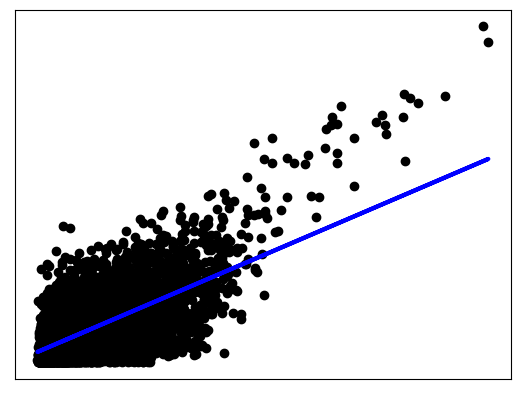

In [71]:
plt.scatter(x, y,  color='black')
plt.plot(x, lnr.predict(x), color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

# Tackle Effectiveness and Coverage for Overall Positions

I want to look at how Tackle Effectiveness and Tackle Covereage can be viewed from an overall player positions perspective. 

In [72]:
weeks_predict_positions = weeks_predict_matrix.copy()

In [73]:
weeks_predict_positions = weeks_predict_positions[['nflId', 'TackleCoverage', 'tackles', 'position', 'TackleEffectiveness']]

In [74]:
weeks_predict_positions['ave_TackleCoverage'] = weeks_predict_positions.groupby('position')['TackleCoverage'].transform('mean')
weeks_predict_positions['ave_tackles'] = weeks_predict_positions.groupby('position')['tackles'].transform('mean')
weeks_predict_positions['ave_TackleEffectiveness'] = weeks_predict_positions.groupby('position')['TackleEffectiveness'].transform('mean')

In [75]:
weeks_predict_positions = weeks_predict_positions.drop_duplicates('position', keep='first')
weeks_predict_positions = weeks_predict_positions.drop('TackleCoverage', axis=1)
weeks_predict_positions = weeks_predict_positions.drop('tackles', axis=1)
weeks_predict_positions = weeks_predict_positions.drop('TackleEffectiveness', axis=1)
weeks_predict_positions = weeks_predict_positions[weeks_predict_positions['position'].notna()]

In [76]:
weeks_predict_positions

,nflId,position,ave_TackleCoverage,ave_tackles,ave_TackleEffectiveness
149,43294.00,CB,7.05,21.43,6.65
1161,53532.00,ILB,7.73,50.05,7.09
4541,43298.00,DE,7.37,17.52,7.19
5789,52492.00,OLB,7.97,30.54,7.20
10173,46232.00,DT,6.44,18.95,7.10
12278,40166.00,SS,8.60,34.24,8.55
17864,40107.00,FS,8.50,32.20,8.74
122934,38607.00,MLB,8.23,31.74,7.52
284898,47973.00,NT,6.33,18.53,7.10
1054053,52416.00,DB,10.55,30.00,8.05


Free safeties and strong safeties appear to have the highest levels of both metrics. But that is probable because they have to cover long distances to tackle on run plays where the ball carrier has gone past the front line and linebackers. Whereas cornerbacks appear to be making tackles on passes where the receiver caught the ball in relatively coverage, hence their lower numbers. As expected the defensive line is probably making tackles on running backs near the line of scrimmage, and linebackers are making tackles a bit farther back from that. 

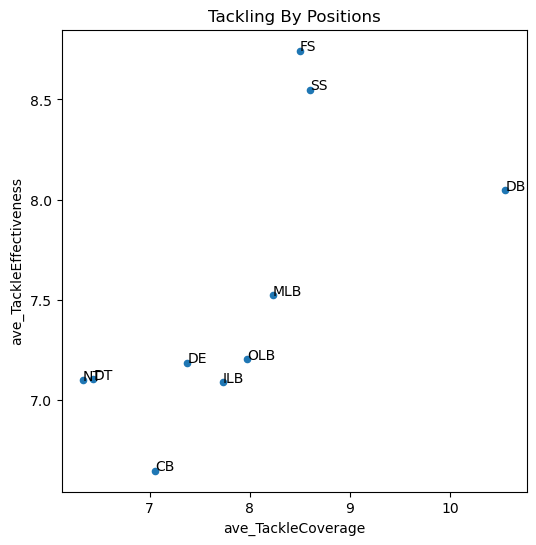

In [77]:
ax = weeks_predict_positions.plot(kind='scatter', x='ave_TackleCoverage', y='ave_TackleEffectiveness', 
                                  title='Tackling By Positions', figsize=(6,6))
weeks_predict_positions[['ave_TackleCoverage','ave_TackleEffectiveness','position']].apply(lambda row: ax.text(*row),axis=1);

In [78]:
weeks_predict_run_positions = weeks_predict_matrix[weeks_predict_matrix['playType']=='run']
weeks_predict_pass_positions = weeks_predict_matrix[weeks_predict_matrix['playType']=='pass']

In [79]:
weeks_predict_run_positions = weeks_predict_run_positions[['TackleCoverage', 'tackles', 'position', 'TackleEffectiveness']]
weeks_predict_run_positions['ave_TackleCoverage'] = weeks_predict_run_positions.groupby('position')['TackleCoverage'].transform('mean')
weeks_predict_run_positions['ave_TackleEffectiveness'] = weeks_predict_run_positions.groupby('position')['TackleEffectiveness'].transform('mean')
weeks_predict_run_positions['ave_tackles'] = weeks_predict_run_positions.groupby('position')['tackles'].transform('mean')
weeks_predict_run_positions = weeks_predict_run_positions.drop_duplicates('position', keep='first')
weeks_predict_run_positions = weeks_predict_run_positions.drop('TackleCoverage', axis=1)
weeks_predict_run_positions = weeks_predict_run_positions.drop('TackleEffectiveness', axis=1)
weeks_predict_run_positions = weeks_predict_run_positions.drop('tackles', axis=1)
weeks_predict_run_positions = weeks_predict_run_positions[weeks_predict_run_positions['position'].notna()]

In [80]:
weeks_predict_pass_positions = weeks_predict_pass_positions[['TackleCoverage', 'tackles', 'position', 'TackleEffectiveness']]
weeks_predict_pass_positions['ave_TackleCoverage'] = weeks_predict_pass_positions.groupby('position')['TackleCoverage'].transform('mean')
weeks_predict_pass_positions['ave_TackleEffectiveness'] = weeks_predict_pass_positions.groupby('position')['TackleEffectiveness'].transform('mean')
weeks_predict_pass_positions['ave_tackles'] = weeks_predict_pass_positions.groupby('position')['tackles'].transform('mean')
weeks_predict_pass_positions = weeks_predict_pass_positions.drop_duplicates('position', keep='first')
weeks_predict_pass_positions = weeks_predict_pass_positions.drop('TackleCoverage', axis=1)
weeks_predict_pass_positions = weeks_predict_pass_positions.drop('TackleEffectiveness', axis=1)
weeks_predict_pass_positions = weeks_predict_pass_positions.drop('tackles', axis=1)
weeks_predict_pass_positions = weeks_predict_pass_positions[weeks_predict_pass_positions['position'].notna()]

It's interesting comparing running plays and passing plays. On passing plays when defensive linemen are making tackles they are covering large distances as they chase passes completed either away from the line of scrimmage or on screen pasese where they are not near the ball carrier when they catch it. 

It is the reverse for defensive backs. On pass plays they are making tackles on receivers catching the ball near them in probably pretty tight coverage. Whereas on running plays they have to cover more ground to tackle running backs that have gotten past the first two lines of defense. 

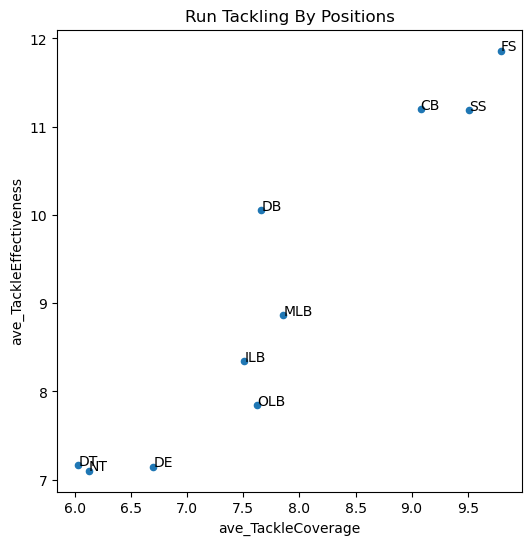

In [81]:
ax = weeks_predict_run_positions.plot(kind='scatter', x='ave_TackleCoverage', y='ave_TackleEffectiveness', 
                                      title='Run Tackling By Positions', figsize=(6,6))
weeks_predict_run_positions[['ave_TackleCoverage','ave_TackleEffectiveness','position']].apply(lambda row: ax.text(*row),axis=1);

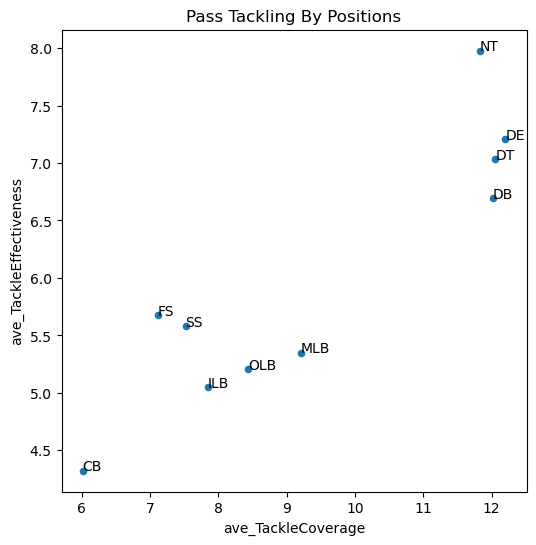

In [82]:
ax = weeks_predict_pass_positions.plot(kind='scatter', x='ave_TackleCoverage', y='ave_TackleEffectiveness', 
                                       title='Pass Tackling By Positions', figsize=(6,6))
weeks_predict_pass_positions[['ave_TackleCoverage','ave_TackleEffectiveness','position']].apply(lambda row: ax.text(*row),axis=1);

# Looking at Players Within A Position

I want to take a look at how players compare within their position. For illustration purposes I want to look at a position that has a smaller number of tackles so the graph is less cluttered. 

In [83]:
weeks_predict_players = weeks_predict_matrix.copy()
weeks_predict_players = weeks_predict_players[['nflId', 'position']]
weeks_predict_players = weeks_predict_players.drop_duplicates('nflId', keep='first')
weeks_predict_players['position'].value_counts()

CB     175
OLB    131
DT     118
DE     110
ILB     85
FS      65
SS      61
NT      29
MLB     10
DB       1
Name: position, dtype: int64

With only 10 players listed at that position, I'll look at middle linebackers. 

In [84]:
weeks_predict_mlb = weeks_predict_matrix[weeks_predict_matrix['position']=='MLB']

In [85]:
weeks_predict_mlb = weeks_predict_mlb[['TackleCoverage', 'tackles', 'displayName', 'TackleEffectiveness']]
weeks_predict_mlb['ave_TackleCoverage'] = weeks_predict_mlb.groupby('displayName')['TackleCoverage'].transform('mean')
weeks_predict_mlb['ave_TackleEffectiveness'] = weeks_predict_mlb.groupby('displayName')['TackleEffectiveness'].transform('mean')
weeks_predict_mlb['ave_tackles'] = weeks_predict_mlb.groupby('displayName')['tackles'].transform('mean')
weeks_predict_mlb = weeks_predict_mlb.drop_duplicates('displayName', keep='first')
weeks_predict_mlb = weeks_predict_mlb.drop('TackleCoverage', axis=1)
weeks_predict_mlb = weeks_predict_mlb.drop('TackleEffectiveness', axis=1)
weeks_predict_mlb = weeks_predict_mlb.drop('tackles', axis=1)

In [86]:
weeks_predict_mlb

,displayName,ave_TackleCoverage,ave_TackleEffectiveness,ave_tackles
122934,Demario Davis,6.91,5.63,40.00
173002,Anthony Walker,8.41,6.59,14.00
233964,Jacob Phillips,6.66,7.39,40.00
241648,Damien Wilson,8.24,6.41,23.00
1402592,Cody Barton,10.07,9.98,44.00
2664213,Tyrel Dodson,9.03,5.05,11.00
4898511,Shaquille Leonard,7.51,8.43,10.00
4988383,Jaylon Smith,8.65,7.62,22.00
10969551,Jordan Kunaszyk,10.36,8.75,2.00
10620405,David Mayo,25.51,32.36,1.00


In [87]:
# To drop an outlier player
weeks_predict_mlb = weeks_predict_mlb[weeks_predict_mlb.displayName != 'David Mayo']

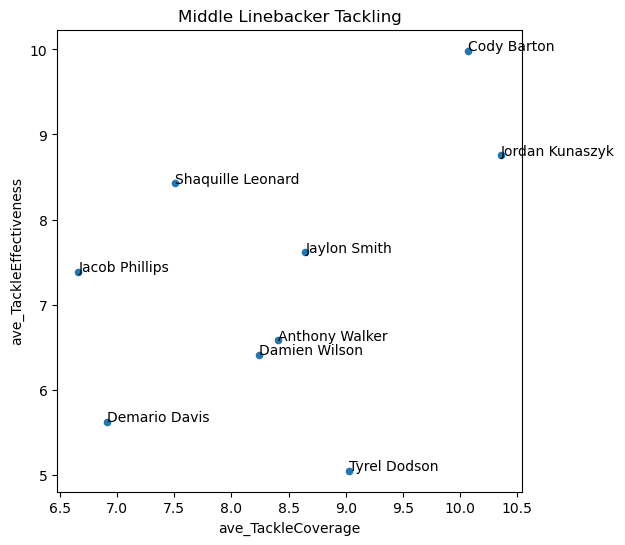

In [88]:
ax = weeks_predict_mlb.plot(kind='scatter', x='ave_TackleCoverage', y='ave_TackleEffectiveness', 
                            title='Middle Linebacker Tackling', figsize=(6,6))
weeks_predict_mlb[['ave_TackleCoverage','ave_TackleEffectiveness','displayName']].apply(lambda row: ax.text(*row),axis=1);

# Looking At Players On A Team

Since Kansas City won the Super Bowl that season, I'll take a look at tackling for them. 

In [89]:
weeks_predict_kc = weeks_predict_matrix[weeks_predict_matrix['defensiveTeam']=='KC']
weeks_predict_kc = weeks_predict_kc[['displayName', 'TackleCoverage', 'tackles', 'position', 'TackleEffectiveness']]
weeks_predict_kc['ave_TackleCoverage'] = weeks_predict_kc.groupby('displayName')['TackleCoverage'].transform('mean')
weeks_predict_kc['ave_TackleEffectiveness'] = weeks_predict_kc.groupby('displayName')['TackleEffectiveness'].transform('mean')
weeks_predict_kc = weeks_predict_kc.drop_duplicates('displayName', keep='first')
weeks_predict_kc = weeks_predict_kc.drop('TackleCoverage', axis=1)
weeks_predict_kc = weeks_predict_kc.drop('TackleEffectiveness', axis=1)

In [90]:
weeks_predict_kc

,displayName,tackles,position,ave_TackleCoverage,ave_TackleEffectiveness
1007971,Nick Bolton,63,ILB,7.39,6.53
1018175,L'Jarius Sneed,44,CB,8.52,8.55
1021122,Trent McDuffie,2,CB,31.44,30.44
1036327,Rashad Fenton,16,CB,5.57,5.96
1042697,Justin Reid,28,SS,9.78,11.59
1048574,Willie Gay,25,OLB,6.20,5.45
1061549,Bryan Cook,11,SS,7.02,5.84
1064476,Frank Clark,12,DE,6.99,7.12
1067835,Juan Thornhill,28,FS,7.80,9.78
1079534,George Karlaftis,16,DE,8.70,7.93


To eliminate an outlier with low tackles, but very high average transfer to tackle. 

In [91]:
weeks_predict_kc = weeks_predict_kc[weeks_predict_kc.displayName != 'Trent McDuffie']
weeks_predict_kc = weeks_predict_kc[weeks_predict_kc.displayName != 'Deon Bush']

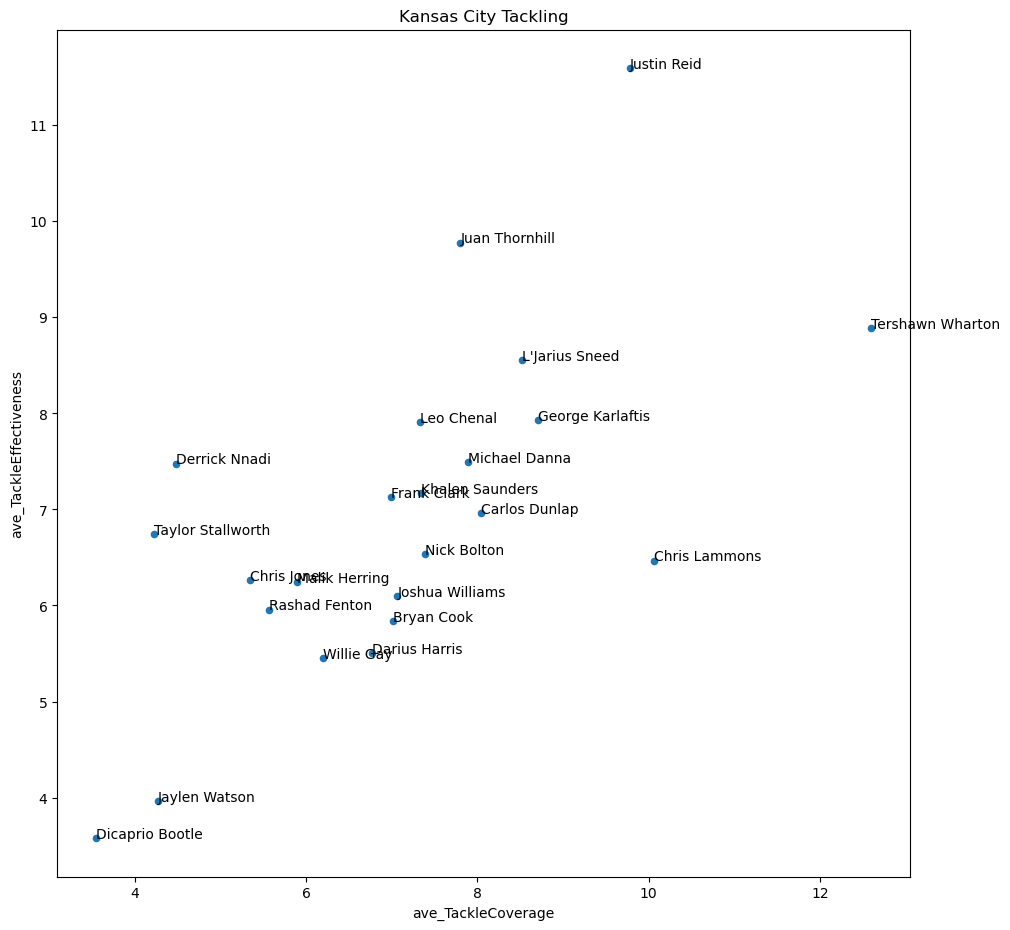

In [92]:
ax = weeks_predict_kc.plot(kind='scatter', x='ave_TackleCoverage', y='ave_TackleEffectiveness', 
                           title='Kansas City Tackling', figsize=(11,11))
weeks_predict_kc[['ave_TackleCoverage','ave_TackleEffectiveness','displayName']].apply(lambda row: ax.text(*row),axis=1);

From earlier I measured the linear regression line on the overall dataset of over 13,000 rows as y = 0.64x + 2.3224. I wanted to see how L'Jarius Sneed's Tackle Effectivess would change if his Tackle Coverage was reduced from 8.52 to 7. In this case it was reduced from 8.55 to 6.80.

The following chart shows how version 2 of L'Jarius Sneed would compare to his actual numbers. 

In [93]:
y = .64*7+2.3225
y

6.8025

In [94]:
weeks_predict_kc.loc[-1] = ["L'Jarius Sneed v2", 44, 'CB', 7, 6.8025]
weeks_predict_kc

,displayName,tackles,position,ave_TackleCoverage,ave_TackleEffectiveness
1007971,Nick Bolton,63,ILB,7.39,6.53
1018175,L'Jarius Sneed,44,CB,8.52,8.55
1036327,Rashad Fenton,16,CB,5.57,5.96
1042697,Justin Reid,28,SS,9.78,11.59
1048574,Willie Gay,25,OLB,6.20,5.45
1061549,Bryan Cook,11,SS,7.02,5.84
1064476,Frank Clark,12,DE,6.99,7.12
1067835,Juan Thornhill,28,FS,7.80,9.78
1079534,George Karlaftis,16,DE,8.70,7.93
1080056,Khalen Saunders,26,DT,7.34,7.17


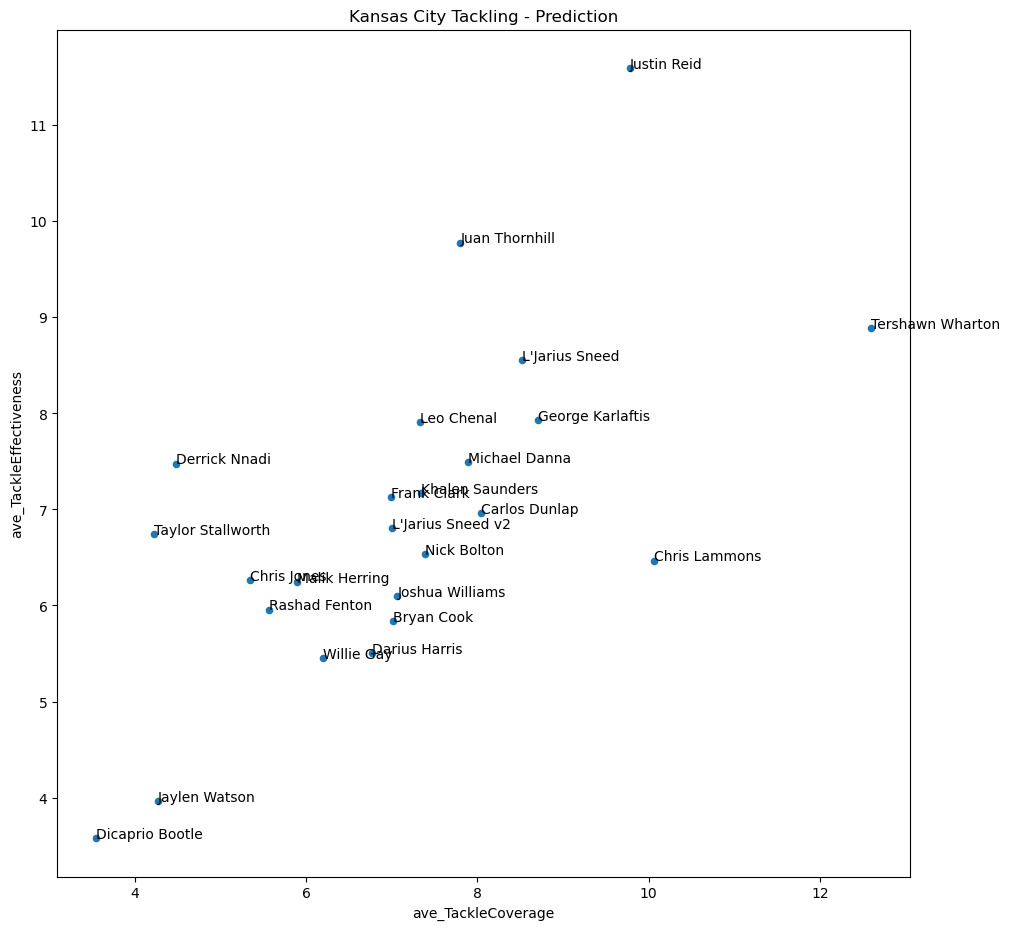

In [95]:
ax = weeks_predict_kc.plot(kind='scatter', x='ave_TackleCoverage', y='ave_TackleEffectiveness', 
                           title='Kansas City Tackling - Prediction', figsize=(11,11))
weeks_predict_kc[['ave_TackleCoverage','ave_TackleEffectiveness','displayName']].apply(lambda row: ax.text(*row),axis=1);

# Looking at Overall Teams

It will be insteresting to see how the Tackling Effectiveness and Coverage look for all teams.

In [96]:
weeks_predict_teams = weeks_predict_matrix.copy()

In [97]:
weeks_predict_teams = weeks_predict_teams[['TackleCoverage', 'playResult', 'defensiveTeam', 'TackleEffectiveness']]
weeks_predict_teams['ave_TackleCoverage'] = weeks_predict_teams.groupby('defensiveTeam')['TackleCoverage'].transform('mean')
weeks_predict_teams['ave_TackleEffectiveness'] = weeks_predict_teams.groupby('defensiveTeam')['TackleEffectiveness'].transform('mean')
weeks_predict_teams['ave_playResult'] = weeks_predict_teams.groupby('defensiveTeam')['playResult'].transform('mean')
weeks_predict_teams = weeks_predict_teams.drop_duplicates('defensiveTeam', keep='first')
weeks_predict_teams = weeks_predict_teams.drop('TackleCoverage', axis=1)
weeks_predict_teams = weeks_predict_teams.drop('TackleEffectiveness', axis=1)
weeks_predict_teams = weeks_predict_teams.drop('playResult', axis=1)

In [98]:
weeks_predict_teams

,defensiveTeam,ave_TackleCoverage,ave_TackleEffectiveness,ave_playResult
149,LA,7.03,7.29,5.28
8001,BUF,8.30,6.78,5.69
80173,NO,7.01,6.73,5.17
86075,ATL,7.07,7.20,6.57
173002,CLE,7.68,7.91,5.96
176027,CAR,7.74,6.99,5.32
265570,SF,7.57,7.06,5.61
267111,CHI,8.04,7.82,6.23
372722,CIN,7.65,7.57,6.09
376049,PIT,7.16,7.09,6.22


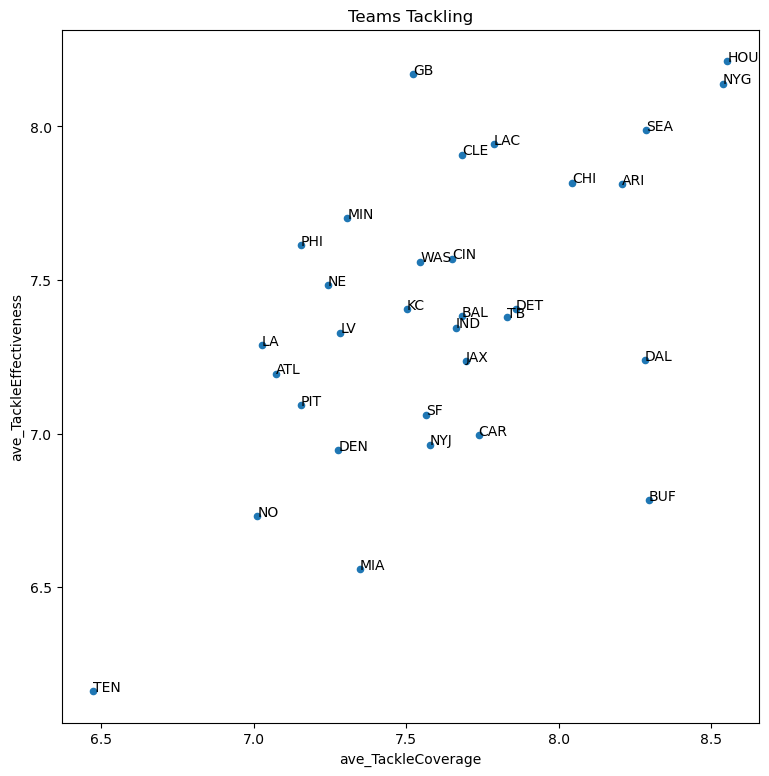

In [99]:
ax = weeks_predict_teams.plot(kind='scatter', x='ave_TackleCoverage', y='ave_TackleEffectiveness', 
                              title='Teams Tackling', figsize=(9,9))
weeks_predict_teams[['ave_TackleCoverage','ave_TackleEffectiveness','defensiveTeam']].apply(lambda row: ax.text(*row),axis=1);

From earlier I measured the linear regression line on the overall dataset of over 13,000 rows as y = 0.64x + 2.3224. I wanted to see how one team's, Philadelphia (Kansas City's opponent in the Super Bowl) in this example, Tackle Effectivess would change if their Tackle Coverage was reduced from 7.15 to 6.75. In this case it was reduced from 7.61 to 6.64.

The following chart shows how version 2 of Philadelphia would compare to their original numbers.

In [100]:
y = .64*6.75 + 2.3224
y

6.6424

In [101]:
weeks_predict_teams.loc[-1] = ["PHI v2", 6.75, 6.6424, 6.39]

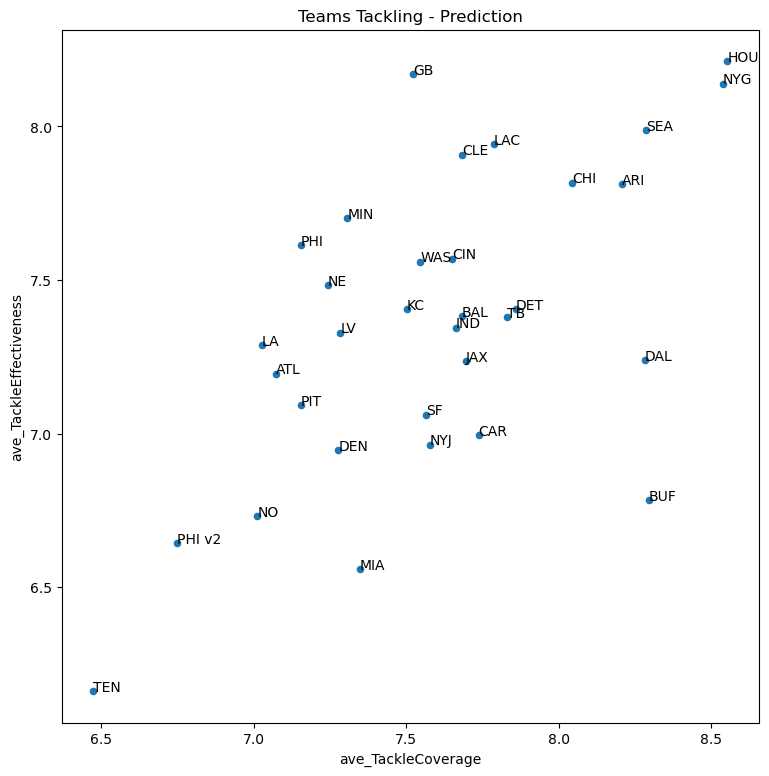

In [102]:
ax = weeks_predict_teams.plot(kind='scatter', x='ave_TackleCoverage', y='ave_TackleEffectiveness', 
                              title='Teams Tackling - Prediction', figsize=(9,9))
weeks_predict_teams[['ave_TackleCoverage','ave_TackleEffectiveness','defensiveTeam']].apply(lambda row: ax.text(*row),axis=1);

# Effects of Offensive & Defensive Formations

Here I wanted to take a preliminary look at how Tackle Coverage would look when the different offensive and defensive formations are matched against each other. 

In [103]:
formations

,ave_defendersInTheBox,offenseFormation,ave_TackleCoverage,defensiveTeam
149,6.00,SHOTGUN,4.01,LA
1161,6.00,EMPTY,6.77,LA
1436,6.00,I_FORM,4.89,LA
2384,6.00,SHOTGUN,12.01,LA
4541,6.00,EMPTY,6.91,LA
...,...,...,...,...
12140438,6.00,PISTOL,5.13,NO
12150622,7.00,WILDCAT,5.48,BAL
12171983,6.00,SHOTGUN,18.31,BAL
12173124,6.00,SHOTGUN,4.15,BAL


In [104]:
formations = formations[formations.offenseFormation != 'JUMBO']
formations = formations[formations.offenseFormation != 'WILDCAT']
formations = formations[formations.offenseFormation != 'PISTOL']
formations = formations[formations.offenseFormation != 0]
formations = formations[formations.ave_defendersInTheBox != 1]
formations = formations[formations.ave_defendersInTheBox != 11]
formations = formations[formations.ave_defendersInTheBox != 10]
formations = formations[formations.ave_defendersInTheBox != 9]
formations = formations[formations.ave_defendersInTheBox != 3]
formations = formations[formations.ave_defendersInTheBox != 0]

In [105]:
table = pd.pivot_table(formations, values='ave_TackleCoverage', index='ave_defendersInTheBox',
                       columns=['offenseFormation'], aggfunc="mean", margins="True", margins_name='Overall',)
table = table.assign(sortkey=table.index == 'Overall')\
                .sort_values(['sortkey','Overall'], ascending=[False, True])\
                .drop('sortkey', axis=1)
table

offenseFormation,EMPTY,I_FORM,SHOTGUN,SINGLEBACK,Overall
ave_defendersInTheBox,,,,,
Overall,7.49,7.91,7.32,8.02,7.60
5.0,7.05,13.66,7.28,8.87,7.26
8.0,11.39,7.66,6.79,7.65,7.49
6.0,7.60,7.79,7.33,8.28,7.57
7.0,8.75,8.10,7.34,8.00,7.78
4.0,7.85,7.79,7.80,5.27,7.80


In [106]:
table_amount = pd.pivot_table(formations, values='ave_TackleCoverage', index='ave_defendersInTheBox',
                       columns=['offenseFormation'], aggfunc="sum", margins="True", margins_name='Overall')
table_amount = table_amount.assign(sortkey=table.index == 'Overall')\
                .sort_values(['sortkey','Overall'], ascending=[False, True])\
                .drop('sortkey', axis=1)
table_amount

offenseFormation,EMPTY,I_FORM,SHOTGUN,SINGLEBACK,Overall
ave_defendersInTheBox,,,,,
4.0,675.45,15.57,1286.81,10.55,1988.38
5.0,1769.00,13.66,4591.40,186.24,6560.31
8.0,11.39,2044.80,1405.70,4699.90,8161.79
7.0,341.16,3125.61,7593.34,10709.76,21769.88
6.0,1884.22,895.40,21208.30,7886.89,31874.80
Overall,4681.22,6095.04,36085.56,23493.33,70355.15
